# Data Challenge for Univ of Chicago Research Position

In [8]:
import pandas as pd
import PIL
from PIL import Image 
import pytesseract 
import sys 
from pdf2image import convert_from_path 
import os
import csv,math
import matplotlib.pyplot as plt

# Task 1

In [14]:
def extract_data(file):
    fname = file+".pdf"
    pages = convert_from_path(fname,500)
    image_counter = 1
    for page in pages:
        filename = "page_"+str(image_counter)+".jpg"
        page.save(filename,'JPEG')
        image_counter=image_counter+1
    filelimit=image_counter-1
    outputfile = file+".txt"
    f = open(outputfile,"a")
    for i in range(1,filelimit+1):
        filename="page_"+str(i)+".jpg"
        text = str(((pytesseract.image_to_string(Image.open(filename)))))
        text = text.replace('-/n',"")
        f.write(text)
    f.close()    

In [24]:
def get_news_sites(txt_file,header):
    file = open(txt_file)
    websites = []
    with open("all_sites.csv",mode="a") as all_csv:
        all_csv_writer = csv.writer(all_csv,delimiter=",")
        if header == 1:
            all_csv_writer.writerow(["file_name","website"])
    
        for line in file.readlines():
            line = line.split()
            for word in line:
                if ".com" in word and "@" not in word:
                    websites.append(word)
                    all_csv_writer.writerow([txt_file,word])
    #### NEWS SITES
    key_news = ["media","news","reports","daily","post","gazette"]
    news_sites = []
    with open("news_sites_output.csv",mode="a") as news_csv_file:
        news_csv = csv.writer(news_csv_file,delimiter=",")
        if header == 1:
            news_csv.writerow(["file_name","website"])
        for website in websites:
            for key in key_news:
                if key in website:
                    news_csv.writerow([txt_file,website])

### "Domains (Name.com).pdf"

In [25]:
extract_data("Domains (Name.com)")
get_news_sites("Domains (Name.com).txt",0)

### "Part15 PX2 Declaration WIllis GoDaddy.pdf"

In [23]:
extract_data("Part15 PX2 Declaration WIllis GoDaddy")
get_news_sites("Part15 PX2 Declaration WIllis GoDaddy.txt",1)

# Task 2

In [2]:
from bs4 import BeautifulSoup 
import requests
import re
import numpy as np
from selenium import webdriver

from selenium.webdriver.common.keys import Keys

from selenium.webdriver.common.by import By

import time

In [56]:
driver = webdriver.Chrome(executable_path="/Users/rubinakabir/Documents/interview/chromedriver")

In [185]:
url = "https://oehha.ca.gov/chemicals"
driver.get(url)

In [192]:
count = 0
chemical_df = pd.DataFrame(columns=["Chemical","Url"])
c = 0
while (True):
    time.sleep(1)
    try:
        driver.get(url)
    except:
        print(url)
        break
    # Get element names and URLs
    my_elemts_urls = driver.find_elements_by_xpath("//tbody")[0].find_elements_by_xpath("//a[@href]")
    for element in my_elemts_urls:
        chem_url = element.get_attribute("href") 
        if "?" not in chem_url and "#" not in chem_url and "csv" not in chem_url and "chemicals" in chem_url:
            chemical_df.loc[count] = [element.text,chem_url]
            count = count + 1
    xpath = "//a[contains(@title,'Go to next page')]"
    try:
        url = driver.find_elements_by_xpath(xpath)[0].get_attribute("href") 
    except:
        break

In [189]:
chemical_urls = chemical_df["Url"].values.tolist()
count = 0
all_dates = []
all_uses = []
for chem_url in chemical_urls:
    time.sleep(1)
    driver.get(chem_url)
    ######## Get Dates #########
    xpath = "//tr[th//text()[contains(.,'Date of Listing')]]"
    dates = driver.find_elements_by_xpath(xpath)
    chem_dates = []
    for date in dates:
        parse_date = date.text.rfind(":")
        date = date.text[parse_date+2:].strip()
        chem_dates.append(date)
    all_dates.append(chem_dates)
   ######## Get Uses #######
    xpath = "//div[contains(@class,group-left)]//p"
    try:
        use = driver.find_elements_by_xpath(xpath)[1].text
    except:
        use = []
    all_uses.append(use)
chemical_df["Dates"] = all_dates
chemical_df["Uses"] = all_uses

In [191]:
chemical_df.to_csv("chemical_data.csv")

# Task 3

In [196]:
data = pd.read_csv("2011_Transactions.csv", encoding = "ISO-8859-1", engine='python')
data = data[["machine_id","site_session_id","event_date","event_time",
             "prod_category_id"]]
#43 - flight
#45- car
#44 - hotel

In [197]:
users = data.machine_id.unique()
means_df = pd.DataFrame(columns=["total_trans_mean","Flights Mean","Rental Car Mean","Hotel Mean"])
for user in users:
    get_rows = list((data["machine_id"] == user))
    cat_43 = sum(data[get_rows]["prod_category_id"] == 43)/sum(get_rows)
    cat_44 = sum(data[get_rows]["prod_category_id"] == 44)/sum(get_rows)
    cat_45 = sum(data[get_rows]["prod_category_id"] == 45)/sum(get_rows)
    means_df.loc[user,"total_trans_mean"] = sum(get_rows)/data.shape[0]
    means_df.loc[user,"Flights Mean"] = cat_43
    means_df.loc[user,"Rental Car Mean"] = cat_44
    means_df.loc[user,"Hotel Mean"] = cat_45
means_df.to_csv("task_3_means.csv")

In [198]:
condition = (data["prod_category_id"] == 43) | (data["prod_category_id"] == 44) |(data["prod_category_id"] == 45)
data = data.loc[condition]
multi_trans = data[data.loc[condition].duplicated(['machine_id'],keep=False)]
multi_trans = multi_trans.drop_duplicates()
multi_trans.sort_values("machine_id", ascending=True, inplace=False)
multi_trans.head()
users = multi_trans.machine_id.unique()

#### extract hour and minute from time of event to document sequence

In [199]:
for user in users:
    get_rows = (multi_trans["machine_id"] == user)
    
    get_trans_ind = list(multi_trans[get_rows].index)
    
    times = list(multi_trans[get_rows]["event_time"])
    dates = multi_trans[get_rows]["event_date"]
    
    if len(get_trans_ind) == 1:
        if type(times[0]) is float : continue
        h = times[0].find(":")
        m = times[0].rfind(":")
        hour = int(times[0][0:h])
        minute = int(times[0][h+1:m])
        
        multi_trans.loc[get_trans_ind,"hour"] = hour
        multi_trans.loc[get_trans_ind,"min"] = minute
        continue
        
    hours=[] 
    for ind, time in zip(get_trans_ind, times):
        if type(time) is float : continue
        h = time.find(":")
        m = time.rfind(":")
        hour = int(time[0:h])
        minute = int(time[h+1:m])

        multi_trans.loc[ind,"hour"] = hour
        multi_trans.loc[ind,"min"] = minute

#### Check which transactions are related

In [200]:
category_df = pd.DataFrame(columns=["1st Puchase","Second Purchase","Third Purchase","Fourth Purchase"])
for user in users:
    get_rows = (multi_trans["machine_id"] == user)
    t = multi_trans.loc[get_rows]
    cond = (t.groupby(["event_date"]).count() > 1)["machine_id"]
    dates = list(zip(cond,cond.index))
    for customers_dates in dates:
        if customers_dates[0]==True:
            multiple = customers_dates[1]
            get_trans = t[t["event_date"] == multiple].sort_values(by=["hour","min"],ascending=[True,True])
            # If no unique categories, don't analyze
            if get_trans["prod_category_id"].unique().shape[0] < 1:
                continue
            if get_trans["prod_category_id"].unique().shape[0] < 4:
                order = get_trans["prod_category_id"].values
                fix_array = np.array([np.nan]*(4-order.shape[0]))
                category_df.loc[user] = np.append(order,fix_array)
            else:
                category_df.loc[user] = get_trans["prod_category_id"].values
        else:
            continue


In [201]:
first = category_df["1st Puchase"].value_counts()
second = category_df["Second Purchase"].value_counts()
third = category_df["Third Purchase"].value_counts()
fourth = category_df["Fourth Purchase"].value_counts()

<Figure size 1440x720 with 0 Axes>

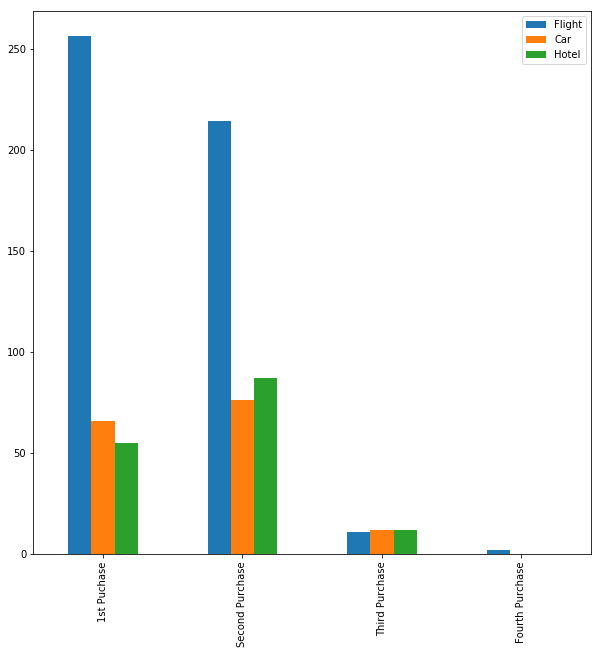

In [215]:
final = pd.DataFrame([first,second,third,fourth])
final.columns = ["Flight","Car","Hotel"]
final.to_csv("related_transactions_summary.csv")
final.plot.bar(figsize=(10,10))